Machine Learning with SciKit-Learn
==================================

*Training a machine to classify things into categories with high accuracy*

<br/>
Yazan Boshmaf

<br/>
More notebooks? Go to [github.com/boshmaf/notebooks](https://github.com/boshmaf/notebooks)

Last updated: February 11, 2016

What is machine learning?
=========================

Using a set of data samples to **predict properties** of similar but **unseen before** data

Each data sample represents a vector of one of more numbers or categories called **features**

A collection of feature vectors is called a **dataset**

For example,
- User Bob has the following feature vector: $($1, "Bob", 24, "USA", "Male"$)$
- User Alice has the following feature vector: $($2, "Alice", 20, "Canada", "Female"$)$
- So 1st feature is ID, 2nd is name, 3rd is age, 4th is nationality, 5th is gender

*For a new user Dave with feature vector $($3, "Bob", 23, "Canada"$)$, what is Dave's gender?*

Supervised machine learning?
============================

We will focus on **supervised** learning problems
- Feature vectors have at least one feature that we want to predict
- This feature is called the **target variable** (e.g., gender)
- Subset of feature vectors already have target values, called **training dataset**
- The rest we want to predict their target values, called **testing or new dataset**
- We can predict "accurately" using a machine learning **algorithm**

If the target variable have discrete or categorical values (e.g., gender), it is called a **label** and the learning problem is called a **classification** problem

*You will learn how to solve classification problems using supervised machine learning!*

![alt txt][supervised_learning]

[supervised_learning]: images/supervised_learning.png "Supervised machine learning"

What is SciKit-Learn?
=====================

Python package for machine learning

Noticable features
- Simple and efficient tools for data mining and data analysis
- Accessible to everybody, and reusable in various contexts
- Built on top of NumPy, SciPy, and MatPlotLib

Go to SciKit-Learn website for more info [scikit-learn.org/stable/index.html](http://scikit-learn.org/stable/index.html)

Building a ground truth
=======================

*Let's predict gender from first names!*

Go to the US Social Security website [ssa.gov/oact/babynames/limits.html](http://www.ssa.gov/oact/babynames/limits.html)

Download the national popular baby names dataset, called `names.zip`
- Click on "National data"
- Uncompress the datasets a into datasets directory

*It's already available to you in the notebook's repo!*

First, we need to get a list of file names

In [1]:
# Ignore those annoying warnings ;-)
import warnings
warnings.filterwarnings('ignore')

# Useful file pattern package
import glob

# Get a list of file names in dataset directory
file_names = glob.glob("datasets/*.txt")

Then, we open and combine their content

In [2]:
# Open files and merge data
dataset = {}
for file_name in file_names:
    file_data = open(file_name)
    for line in file_data:
        line = line.strip()
        data = line.split(",")
        
        name = data[0].lower()
        if name not in dataset:
            dataset[name] = [0,0] # [male_count, female_count]
        
        gender = 0 if data[1] == "M" else 1
        count = int(data[2])
        dataset[name][gender] += count

Let's print dataset summary and checkout the 100th data sample, for example

In [3]:
print "Number of names:", len(dataset)

name = dataset.keys()[100]
print "100th name is:", name

gender_count = dataset[name]
print "Its male count:", gender_count[0]
print "Its female count:", gender_count[1]

Number of names: 92600
100th name is: kinsler
Its male count: 151
Its female count: 18


The dataset has an issue: **Some names are unisex!**

*How big is the issue?*

In [4]:
# Compute ratio of unisex names in dataset
unisex_count = 0
for name in dataset:
    gender_count = dataset[name]
    if gender_count[0] != 0 and gender_count[1] != 0:
        unisex_count += 1
        
print "Number of unisex names:", unisex_count
print "Ratio is dataset: {0:.2f}%".format(100*unisex_count/float(len(dataset)))

Number of unisex names: 10090
Ratio is dataset: 10.90%


We can use gender count to label names as female or not
- Let $C_m(n_i)$ be count of males with name $n_i$
- Similarly, let $C_f(n_i)$ be the count of females with name $n_i$

Now, let a label $\ell(n_i)=1$ means the name $n_i$ **corresponds to a female**, as defined by

$$
\ell(n_i) = 
\begin{cases} 1 &\mbox{if } \displaystyle\frac{C_f(n_i)}{\left(C_f(n_i) + C_m(n_i)\right)} > 0.5, \\ 
0 & \mbox{Otherwise. }
\end{cases}
$$

Accordingly, Kinsler should be labelled as a male with target value of 0, let's do it

In [5]:
# Assign labels to names in dataset
female_count = 0
for name in dataset:
    gender_count = dataset[name]
    if gender_count[1] / float(sum(gender_count)) > 0.5:
        dataset[name] = 1
        female_count += 1
    else:
        dataset[name] = 0
        
print "Number of females:", female_count
print "Ratio is dataset: {0:.2f}%".format(100*female_count/float(len(dataset)))

Number of females: 58777
Ratio is dataset: 63.47%


Let's check back on Kinsler!

In [6]:
name = dataset.keys()[100]
print "100th name is:", name
print "Its gender is:", "Female" if int(dataset[name]) == 1 else "Male"

100th name is: kinsler
Its gender is: Male


*We haven't done machine learning yet; we just built a "low-noise" ground-truth!*

Feature extraction and engineering
==================================

*What are useful features of a name that predict the gender?*

For latin or western names, one can look at
- The last letter
- The last two letter
- Whether the last letter is a vowel

*Example: Philipp vs. Philippa*

Let's extract these features and build our labelled dataset

In [7]:
# Extract features from names
for name in dataset:
    name_features = {}
    name_features["last_letter"] = name[-1]
    name_features["last_two"] = name[-2:]
    name_features["last_is_vowel"] = 1 if name[-1] in "aeiouy" else 0
    name_features["label"] = dataset[name]
    dataset[name] = name_features

Let's look at how the 100th name features looks like

In [8]:
name = dataset.keys()[100]
print "Name is:", dataset.keys()[100]

features = dataset[name]
print "Feature 'last_letter' is:", features["last_letter"]
print "Feature 'last_two' is:", features["last_two"]
print "Feature 'last_is_vowel' is:", features["last_is_vowel"]
print "Label is:", features["label"]

Name is: kinsler
Feature 'last_letter' is: r
Feature 'last_two' is: er
Feature 'last_is_vowel' is: 0
Label is: 0


*We now have a labelled dataset in a feature-value or dictionary format*

Vectorizing the labelled dataset
================================

We need to convert the dataset from feature-value format to vectors

For categorical features, we can do **binary one-of-K** coding
- A binary feature is constructed for each of possible string values a feature can take
- So `last_letter` feature results in up to 26 features

*Example, `last_letter=a`, `last_letter=b`, etc.*

In [9]:
# Dictionary vectorizer from SciKit-Learn package
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
labelled_vectors = vectorizer.fit_transform(dataset.values()).toarray()

The vectorizer also preserves feature names

In [10]:
# Get feature names and label index
feature_names = vectorizer.get_feature_names()
label_index = feature_names.index("label")
feature_names.remove("label")

print "Number of features:", len(feature_names)

Number of features: 468


Finally, we split the labelled vectors into vectors and labels

In [11]:
# Split labelled vectors into labels and vectors
import numpy as np
labels = labelled_vectors[:,label_index]
vectors = np.delete(labelled_vectors, [label_index], axis=1)
print vectors

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 1.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


It's always good to validate we have all data by asserting

In [12]:
# Validate dimensions
assert vectors.shape[0] == len(dataset)
assert vectors.shape[1] == len(feature_names)
assert labels.shape[0] == vectors.shape[0]
print "Dataset vectorized successfully!"

Dataset vectorized successfully!


Training a classifier using Naive Bayes
=======================================

*First, what is Naive Bayes classifier?*

Applies Bayes' theorem with the "naive" assumption of **independence between every pair of features**.

Given a target variable $y$ and a dependent feature vector $(x_1,\dots,x_n)$ of $n$ features, Bayes' theorem states the following relationship:

$$
P(y~|~x_1,\dots,x_n) = \frac{P(y)P(x_1,\dots,x_n~|~y)}{P(x_1,\dots,x_n)}
$$

Using the naive independence assumption that

$$
P(x_i~|~y,x_1,\dots,x_{i-1},x_{i+1},\dots,x_n) = P(x_i~|~y)
$$

And the chaining rule

$$
P(x_1,\dots,x_n~|~y) = P(x_1~|~y)P(x_2,\dots,x_n~|~y)
$$

For all $i$, this relationship simplifies to

$$
P(y~|~x_1,\dots,x_n) = \frac{P(y)\prod_{i=1}^n P(x_i~|~y)}{P(x_1,\dots,x_n)}
$$

Since $P(x_1,\dots, x_n)$ is constant given the input, we can use the following classification rule

$$
P(y \mid x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y) \\ \Downarrow \\ \hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y)
$$

We can use Maximum A Posteriori (MAP) estimation to estimate $P(y)$ and $P(x_i~|~y)$; the former is then the **relative frequency** of class y in the training set.

Different assumptions regarding the distribution of $P(x_i~|~y)$ lead to different classifiers
- We assume data is distributed according to multivariate Bernoulli distributions
- There may be multiple features but each one is assumed to be binary-valued

The decision rule for **Bernoulli naive Bayes** is based on

$$
P(x_i \mid y) = P(i \mid y) x_i + (1 - P(i \mid y)) (1 - x_i)
$$

Alright, let's start the learning process. First, we need to shuffle the data to remove ordering bias

In [13]:
# Import shuffle method
from sklearn.utils import shuffle

# Shuffle the data
rand_state = np.random.RandomState(seed=0)
X, y = shuffle(vectors, labels, random_state=rand_state)

We now slpit the data into 80% training set and 20% testing set

In [14]:
# Split data
training_index = X.shape[0] * 0.8
X_train = X[:training_index]
y_train = y[:training_index]

X_test = X[training_index:]
y_test = y[training_index:]

Always confirm your split was correct

In [15]:
assert (X_train.shape[0] + X_test.shape[0]) == X.shape[0] 
assert (y_train.shape[0] + y_test.shape[0]) == y.shape[0]

assert X_train.shape[1] == X_test.shape[1]

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

print "Data split successfully!"

Data split successfully!


We are ready to train now using a Bernoulli Naive Bayes classifier

In [16]:
# Import the classifier
from sklearn.naive_bayes import BernoulliNB

# Train the classifier
classifier = BernoulliNB()
classifier.fit(X_train, y_train)

print classifier

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)


Testing the classifier
======================

*How accurate is the classifier?*

Let's test the trained classifier using the testing data

In [17]:
# Predict labels of unseen data
y_predicted = classifier.predict(X_test)

We then compute the **accuracy** of the classifier: The fraction of correct predictions.

In [18]:
# Import testing metrics
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_predicted)
print "Classifier accuracy:", accuracy

Classifier accuracy: 0.800647948164


Let's compute the accuracy of the classification problem as a whole
- We first compute the **confusion matrix**, which tells us the number of true positives, true negatives, false positives, and finally, false negatives.
- We then plot it visually as a heatmap!

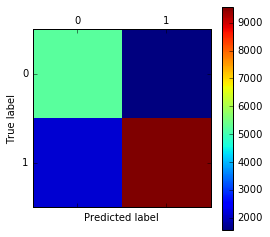

In [19]:
# Enable plotting in the current Notebook
%matplotlib inline

# Import plotting interface
import matplotlib.pyplot as plt

# Import testing metrics
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_predicted)

# Visualize the matrix
plt.matshow(conf_matrix)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

*How about if I have only a name?*

We extract features, vectorize, and then test!

In [20]:
# Import helper functions from utils
import utils

# Get feature vector from name
name = "Christian"
vector = utils.get_vector(name, feature_names, X[0])

# Predict whether name is female
print "Classifier says", name, "is a", "female" if classifier.predict(vector) == 1 else "male"

Classifier says Christian is a male


*A better way to evaluate a classifier is by cross validation and ROC analysis*

Questions? Issues?
==================

Tweet your question to [twitter.com/boshmaf](https://twitter.com/boshmaf) and I'll get back to you

Best way to fix any issue is to open one at [github.com/boshmaf/notebooks](https://github.com/boshmaf/notebooks)